In [1]:
import os, sys
import importlib
import glob
from typing import *

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from scipy import stats

import tqdm

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import data_loader as dl
import featurization as ft
import canonical_models as models
import model_utils
import utils

DEVICE = utils.get_device(3)

FILT_EDIT_DIST = False
N_COMPONENTS = 0.9

if FILT_EDIT_DIST:
    PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/pird_antigen_cv_edit_dist_filt")
else:
    PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/pird_antigen_cv")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)

In [2]:
pird_data = dl.load_pird(with_antigen_only=True)
pird_data = pird_data.loc[~pd.isnull(pird_data['CDR3.beta.aa'])]
pird_data.head()

INFO:root:PIRD data 0.1655 data labelled with antigen sequence
INFO:root:PIRD: Removing 95 entires with non amino acid residues
INFO:root:Entries with antigen sequence: 8429/51044
INFO:root:Unique antigen sequences: 73
INFO:root:PIRD data TRA/TRB instances: Counter({'TRB': 46428, 'TRA': 4011, 'TRA-TRB': 605})
INFO:root:PIRD entries with TRB sequence: 4607
INFO:root:PIRD entries with TRB sequence: 47040
INFO:root:PIRD entries with TRA and TRB:  605


,ICDname,Disease.name,Category,Antigen,Antigen.sequence,HLA,Locus,CDR3.alpha.aa,CDR3.beta.aa,CDR3.alpha.nt,...,Cell.subtype,Prepare.method,Evaluate.method,Case.num,Control.type,Control.num,Filteration,Journal,Pubmed.id,Grade
0,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIEHTNSGGSNYKLTF,CASSLEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIVHTNSGGSNYKLTF,CASSPEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
2,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIVKTNSGGSNYKLTF,CASSFEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1845,A15,Tuberculosis,Pathogen,Rv1195,ADTLQSIGATTVASN,DRB1*15:03,TRA-TRB,CAGAGGGGFKTIF,CASSVALASGANVLTF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1846,A15,Tuberculosis,Pathogen,Rv1195,ADTLQSIGATTVASN,DRB1*15:03,TRA-TRB,CAGPTGGSYIPTF,CASSVALATGEQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5


In [3]:
tcrdb_data = dl.load_tcrdb()
tcrdb_data = tcrdb_data.loc[tcrdb_data['tra_trb'] == 'TRB']
tcrdb_data.head()

INFO:root:Dropping 4 TCRdb entries for unknown TRA TRB status
INFO:root:TCRdb: Removing 0 entries with non-amino acid residues


,accession,RunId,AASeq,cloneFraction,tra_trb
0,PRJNA330606,SRR4102112,CANTGTGFNEQFF,0.008305,TRB
1,PRJNA330606,SRR4102112,CASSHTRGVGTQYF,0.003841,TRB
2,PRJNA330606,SRR4102112,CSGVHEQYF,0.003824,TRB
3,PRJNA330606,SRR4102112,CASSLPNGEGSSYEQYF,0.002825,TRB
4,PRJNA330606,SRR4102112,CASSQGGIAGDVYEQYF,0.002614,TRB


In [4]:
importlib.reload(dl)
tcrdb_neg_rng = np.random.default_rng(seed=64)

def get_perf_comparison(model_dirname:str, n_components=N_COMPONENTS, min_positive:int = 20, max_positive:int=1000, filter_by_edit_dist:bool = FILT_EDIT_DIST):
    """
    Given the directory of a model *that has been trained without a specific antigen*,
    evaluate the performance of that model for generalizing to that excluded antigen
    """
    assert os.path.isdir(model_dirname)

    # Determine the antigen sequence that was hidden from the model's second pretraining step
    held_out_seq = os.path.basename(model_dirname).split("_")[-1]
    
    # Subset to sequences with the held out sequence
    pird_pos_table = pird_data.loc[pird_data['Antigen.sequence'] == held_out_seq]
    pird_pos_trbs = list(pird_pos_table['CDR3.beta.aa'])
    # If we have too few or too many positives
    if len(pird_pos_trbs) < min_positive:  # If we do not have enough positive examples, return None
        return None
    
    print(held_out_seq, len(pird_pos_trbs))
    
    # Get a negative set of sequences from TCRdb, sampled at 5 negatives per positive sequence
    tcrdb_trbs = tcrdb_data['AASeq']
    rand_neg_trbs = list(tcrdb_data.iloc[tcrdb_neg_rng.choice(
        np.arange(len(tcrdb_trbs)), size=int(len(pird_pos_trbs) * 5), replace=False
    )]['AASeq'])

    # Combine positive and negative sequences
    combined_trbs = pird_pos_trbs + rand_neg_trbs
    combined_labels = np.array([1] * len(pird_pos_trbs) + [0] * len(rand_neg_trbs))

    # Find random indices for training and testing sets at 70/30 split
    train_idx, _, test_idx = dl.shuffle_indices_train_valid_test(
        np.arange(len(combined_trbs)), valid=0.0, test=0.3,
    )

    # Further filter by removing training sequences with too much sequence similarity
    if filter_by_edit_dist:
        train_dists = dl.min_dist_train_test_seqs(
            [combined_trbs[i] for i in train_idx],
            [combined_trbs[i] for i in test_idx],
        )
        train_idx = train_idx[np.where(train_dists >= 2)]  # Keep only train seqs at least 2 edits away

    # Create various embeddings to evaluate
    # K-mer featurization
    combined_kmer_ft = np.array([ft.kmer_ft(aa) for aa in combined_trbs])
    # TCR-BERT embedding (without the held-out antigen)
    tcrbert_layer = -1
    cls_embedding = model_utils.get_transformer_embeddings(
        model_dirname,
        combined_trbs,
        method='mean',
        layers=[tcrbert_layer],
        device=3,
    )
    # TCR-BERT embedding (without held-ont antigen and without MLM pre-training)
    cls_no_mlm_embedding = model_utils.get_transformer_embeddings(
        os.path.join("/home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm", os.path.basename(model_dirname)),
        combined_trbs,
        method='mean',
        layers=[tcrbert_layer],
        device=3,
    )
    # TCR-BERT embedding (with only MLM pre-training)
    mlm_embedding = model_utils.get_transformer_embeddings(
        "wukevin/tcr-bert-mlm-only",
        combined_trbs,
        method='mean',
        layers=[tcrbert_layer],
        device=3,
    )
    # External: ESM embed
    esm_embedding = model_utils.get_esm_embedding(combined_trbs, device=1)
    # External: TAPE embed
    tape_embedding = model_utils.get_tape_embedding(combined_trbs, device=2)

    ## Perform evaluation
    eval_preds = {}  # Contains each method's predictions, which we summarize at the end
    # For each embedding, train a PCA-SVM classifier and a LR classifier on top of embedding
    embeds_named = {
        "MLM": mlm_embedding,
        "MLM + CLS": cls_embedding,
        "ESM": esm_embedding,
        "TAPE": tape_embedding,
        "CLS": cls_no_mlm_embedding,
        "k-mers": combined_kmer_ft,
    }
    for embed_name, embed in embeds_named.items():
        logreg = LogisticRegression(solver='liblinear')
        logreg.fit(embed[train_idx], combined_labels[train_idx])
        eval_preds[embed_name + ", LR"] = logreg.predict_proba(embed[test_idx])

        if embed_name == "k-mers":  # Skip over very high-dimensional k-mers for SVM based approaches
            continue

        pcasvm = models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=n_components, cache_size=20 * 1024)
        pcasvm.fit(embed[train_idx], combined_labels[train_idx])
        eval_preds[embed_name + ", PCA-SVM"] = pcasvm.predict_proba(embed[test_idx])

        svm = SVC(probability=True, kernel='rbf', cache_size=20 * 1024)  # 20 GB * 1000 because units are megabytes
        svm.fit(embed[train_idx], combined_labels[train_idx])
        eval_preds[embed_name + ", SVM"] = svm.predict_proba(embed[test_idx])
    
    # SETE requires a separate GBC classifier, so this is handled outside of loop
    pca_gbc = models.ModelOnPCA(
        GradientBoostingClassifier, n_components=0.9,
        learning_rate=0.1, max_features='sqrt',
        n_estimators=70, max_depth=10, loss='deviance',
        random_state=99,
    )
    pca_gbc.fit(combined_kmer_ft[train_idx], combined_labels[train_idx])
    eval_preds['SETE'] = pca_gbc.predict_proba(combined_kmer_ft[test_idx])
    
    # Compute metrics
    retval = pd.Series(
        {
            k: metrics.average_precision_score(combined_labels[test_idx], v[:, 1])
            for k, v in eval_preds.items()
        },
        name=held_out_seq,
    )
    return retval


excl_models = [d for d in glob.glob(
    "/home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_*"
) if os.path.isdir(d)]

get_perf_comparison(excl_models[0])

FPRPWLHGL 88


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

MLM, LR               0.706001
MLM, PCA-SVM          0.747905
MLM, SVM              0.730752
MLM + CLS, LR         0.982026
MLM + CLS, PCA-SVM    0.978539
MLM + CLS, SVM        0.978073
ESM, LR               0.617580
ESM, PCA-SVM          0.608199
ESM, SVM              0.629821
TAPE, LR              0.700013
TAPE, PCA-SVM         0.733292
TAPE, SVM             0.703090
CLS, LR               0.946174
CLS, PCA-SVM          0.921529
CLS, SVM              0.930631
k-mers, LR            0.806263
SETE                  0.770739
Name: FPRPWLHGL, dtype: float64

In [5]:
perf_pairs = [get_perf_comparison(m) for m in tqdm.notebook.tqdm(excl_models)]

FPRPWLHGL 88


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

QIKVRVDMV 24


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_QIKVRVDMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_QIKVRVDMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

EIYKRWII 36


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_EIYKRWII were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_EIYKRWII were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint o

GLCTLVAML 143


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_GLCTLVAML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_GLCTLVAML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

LLWNGPMAV 231


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_LLWNGPMAV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_LLWNGPMAV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

KRWIILGLNK 98


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_KRWIILGLNK were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_KRWIILGLNK were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

TPGPGVRYPL 42


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPGPGVRYPL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPGPGVRYPL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

RFPLTFGWCF 26


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RFPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RFPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

IIKDYGKQM 36


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_IIKDYGKQM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_IIKDYGKQM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

RPHERNGFTVL 21


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RPHERNGFTVL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RPHERNGFTVL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

EPLPQGQLTAY 37


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_EPLPQGQLTAY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_EPLPQGQLTAY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

QIKVRVKMV 28


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_QIKVRVKMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_QIKVRVKMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

NLVPMVATV 4115


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_NLVPMVATV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_NLVPMVATV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

HSKKKCDEL 34


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HSKKKCDEL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HSKKKCDEL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

VTEHDTLLY 201


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_VTEHDTLLY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_VTEHDTLLY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

TPRVTGGGAM 71


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPRVTGGGAM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPRVTGGGAM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

LPPIVAKEI 44


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_LPPIVAKEI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_LPPIVAKEI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

TPQDLNTML 45


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPQDLNTML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPQDLNTML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

RPRGEVRFL 57


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RPRGEVRFL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RPRGEVRFL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

HPVGEADYFEY 24


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HPVGEADYFEY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HPVGEADYFEY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

RYPLTFGWCF 68


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RYPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RYPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

GILGFVFTL 225


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_GILGFVFTL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_GILGFVFTL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

KAFSPEVIPMF 103


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_KAFSPEVIPMF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_KAFSPEVIPMF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

HPKVSSEVHI 53


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HPKVSSEVHI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HPKVSSEVHI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

RAKFKQLL 61


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RAKFKQLL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RAKFKQLL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint o

ATDALMTGY 57


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_ATDALMTGY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_ATDALMTGY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

In [6]:
perf_pairs_df = pd.DataFrame([p for p in perf_pairs if p is not None])
if FILT_EDIT_DIST:
    convnet_perf_df = pd.read_csv("antigen_cv_convnet_baseline_edit_dist_filt.csv", index_col=0).loc[perf_pairs_df.index]
else:
    convnet_perf_df = pd.read_csv("antigen_cv_convnet_baseline.csv", index_col=0).loc[perf_pairs_df.index]
perf_pairs_df['ConvNet'] = convnet_perf_df
perf_pairs_df.head()

,"MLM, LR","MLM, PCA-SVM","MLM, SVM","MLM + CLS, LR","MLM + CLS, PCA-SVM","MLM + CLS, SVM","ESM, LR","ESM, PCA-SVM","ESM, SVM","TAPE, LR","TAPE, PCA-SVM","TAPE, SVM","CLS, LR","CLS, PCA-SVM","CLS, SVM","k-mers, LR",SETE,ConvNet
FPRPWLHGL,0.808718,0.825590,0.796811,0.950252,0.982298,0.982298,0.579969,0.616495,0.624281,0.726191,0.764345,0.736285,0.960841,0.932361,0.935133,0.834859,0.807075,0.850399
QIKVRVDMV,0.811722,0.797222,0.749096,0.932367,0.921147,0.921147,0.359882,0.405477,0.346681,0.369949,0.367722,0.415697,0.807355,0.761883,0.816420,0.804193,0.735362,0.748476
EIYKRWII,0.511435,0.483199,0.516866,0.833731,0.851959,0.851080,0.577979,0.435647,0.567785,0.437454,0.410057,0.465816,0.632267,0.661199,0.684018,0.509170,0.457142,0.384194
GLCTLVAML,0.636319,0.677747,0.658384,0.954800,0.977941,0.978750,0.547122,0.596843,0.557479,0.548029,0.700011,0.580491,0.764391,0.787256,0.797876,0.721826,0.689595,0.718246
LLWNGPMAV,0.714242,0.742217,0.729313,0.908662,0.922653,0.922035,0.531803,0.607056,0.588651,0.602225,0.718854,0.629608,0.751392,0.785538,0.810589,0.683589,0.734823,0.719877


In [7]:
# Average performance for TCR-BERT
np.mean(perf_pairs_df['MLM + CLS, PCA-SVM']), np.mean(perf_pairs_df['MLM + CLS, SVM'])

(0.9106693051150242, 0.9095076266689944)

In [8]:
def num_positives(model_dirname:str, min_positive:int=20, max_positive:int=1000) -> int:
    """
    Given a model dir name, extract the held-out sequence, train a model to predict that
    sequence using the held-out-classifier as well as the MLM-only model. Return performance
    of those two models (MLM, CLS)
    """
    # Determine held out sequence, and get corresponding TRBs
    assert os.path.isdir(model_dirname)
    held_out_seq = os.path.basename(model_dirname).split("_")[-1]
    pird_pos_table = pird_data.loc[pird_data['Antigen.sequence'] == held_out_seq]
    pird_pos_trbs = list(pird_pos_table['CDR3.beta.aa'])
    if len(pird_pos_trbs) < min_positive:# or len(pird_pos_trbs) > max_positive:
        return -1
    return len(pird_pos_trbs)

num_positive_examples = [num_positives(m) for m in excl_models]
num_positive_examples = np.array([i for i in num_positive_examples if i > 0])
min(num_positive_examples), max(num_positive_examples)

(21, 4115)

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Exceed in 26/26 cases


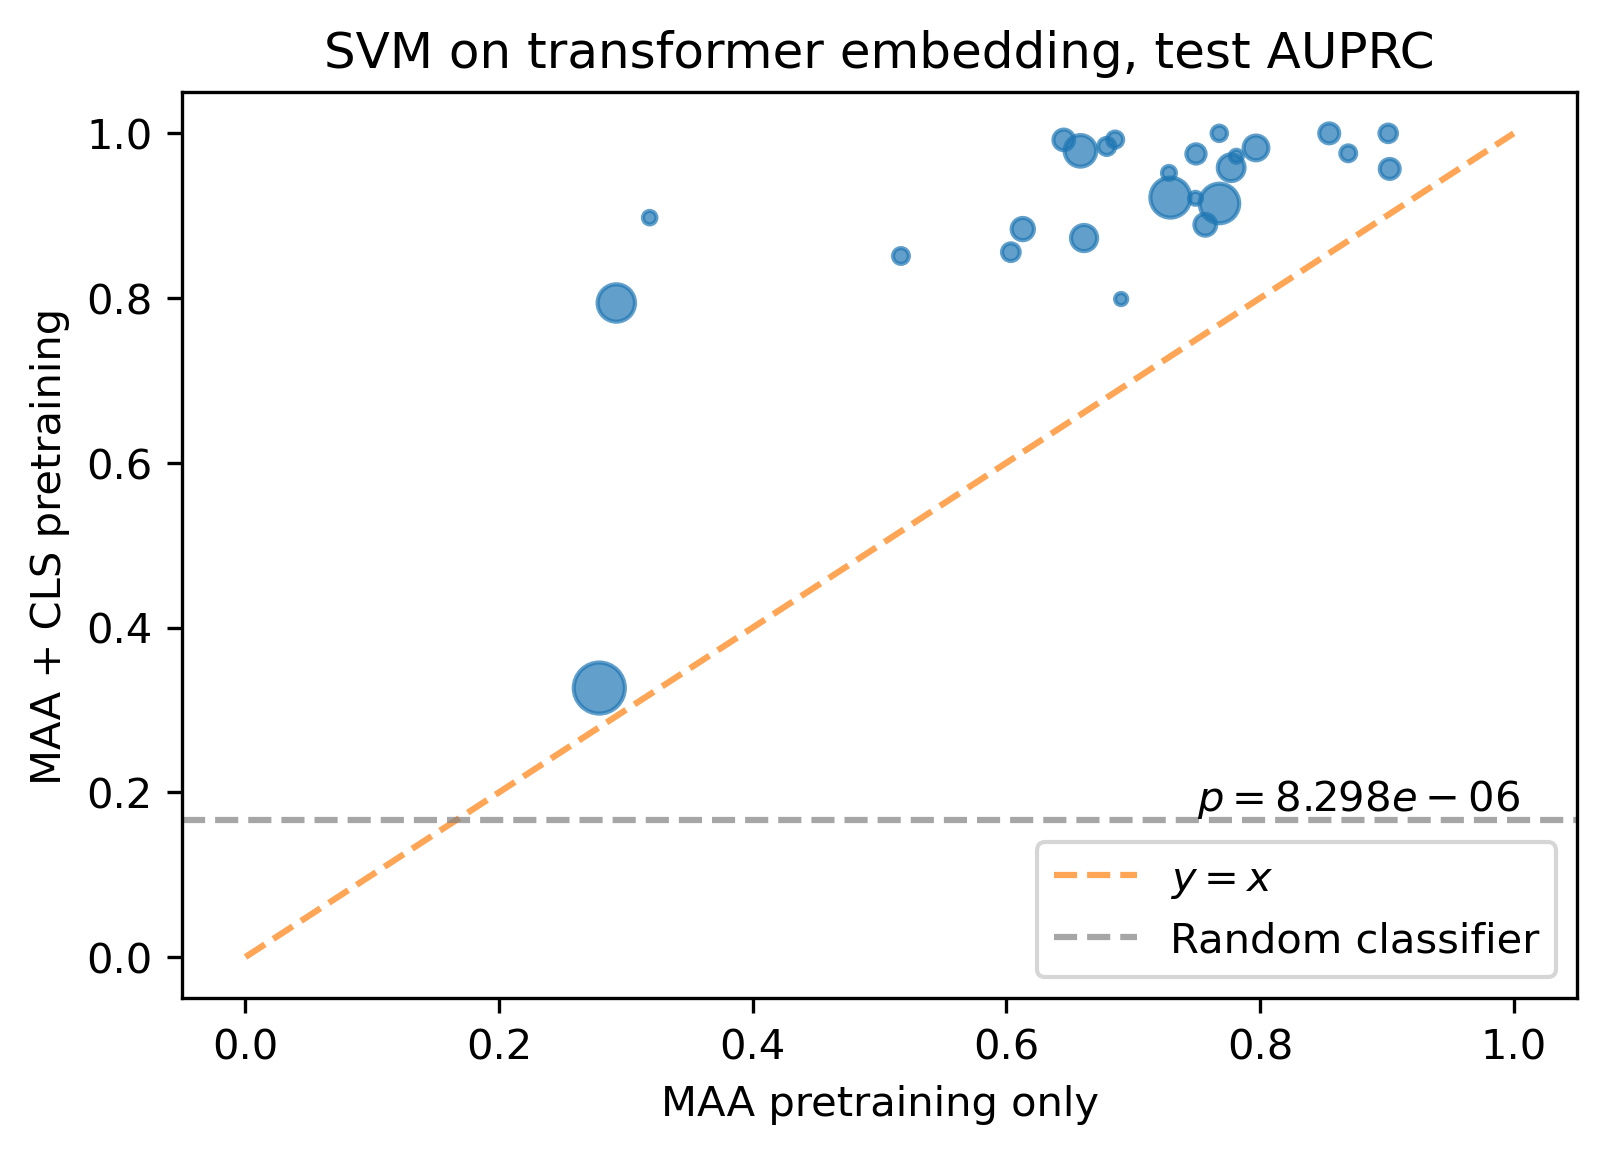

In [9]:
def antigen_cv_plot(
    xaxis:str, yaxis:str,
    annot_p:bool = True,
    alternative:str = "two-sided",
    data:pd.DataFrame = perf_pairs_df,
    fname:Optional[str] = None,
    **kwargs
):
    """
    Scatterplot comparing performance of two methods on xaxis and yaxis
    """
    print(f"Exceed in {np.sum(data[yaxis] > data[xaxis])}/{len(data)} cases")
    sizes = np.minimum(num_positive_examples * 0.4, 150)
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(
        data[xaxis],
        data[yaxis],
        alpha=0.7,
        s=sizes,
    )
    ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label="$y=x$", alpha=0.7)
    ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier", alpha=0.7)
    ax.legend()

    stat, pval = stats.wilcoxon(data[xaxis], data[yaxis], alternative=alternative)
    if annot_p:
        ax.text(0.75, 1/(5+1), f"$p={pval:.4g}$", va='bottom')

    ax.set(**kwargs)
    if fname is not None:
        fig.savefig(fname, bbox_inches='tight')
    return fig

antigen_cv_plot(
    "MLM, SVM",
    "MLM + CLS, SVM",
    xlabel="MAA pretraining only",
    ylabel="MAA + CLS pretraining",
    title="SVM on transformer embedding, test AUPRC",
    fname=os.path.join(PLOT_DIR, "mlm_vs_mlmcls.pdf"),
).show()

Exceed in 25/26 cases


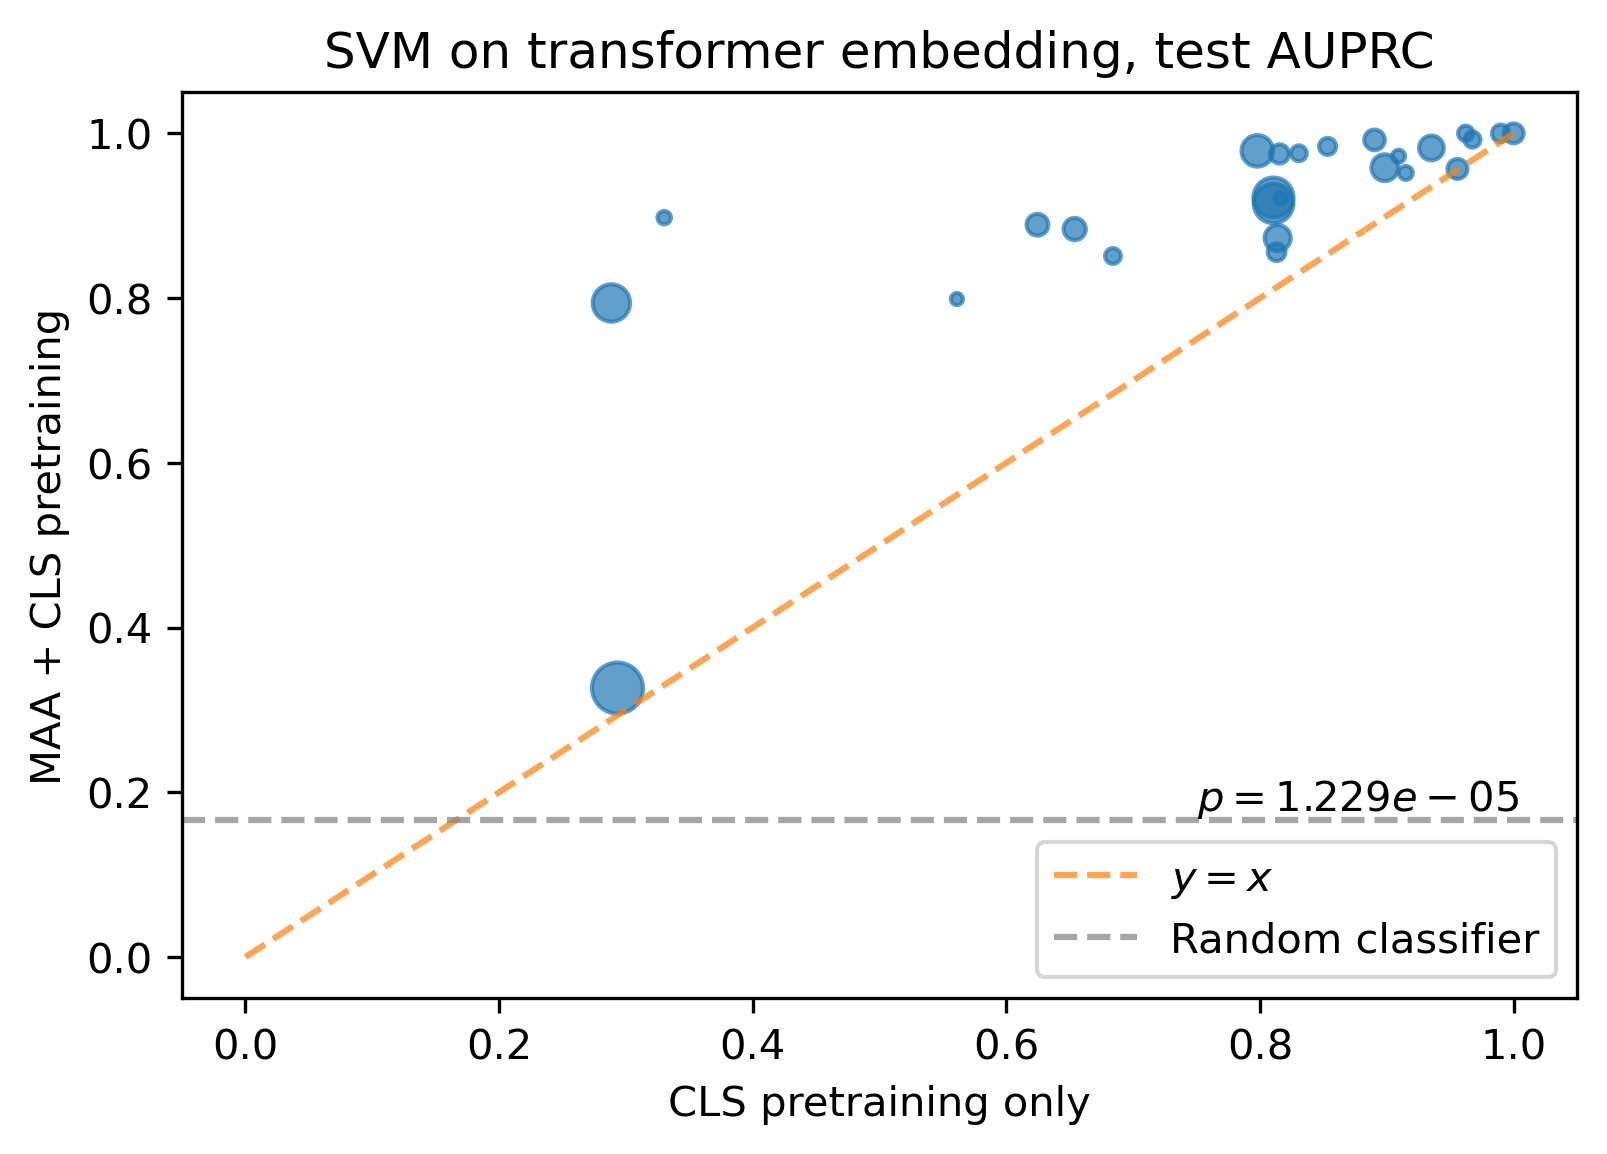

In [10]:
antigen_cv_plot(
    "CLS, SVM",
    "MLM + CLS, SVM",
    xlabel="CLS pretraining only",
    ylabel="MAA + CLS pretraining",
    title="SVM on transformer embedding, test AUPRC",
    fname=os.path.join(PLOT_DIR, "cls_vs_mlmcls.pdf"),
).show()

Exceed in 26/26 cases


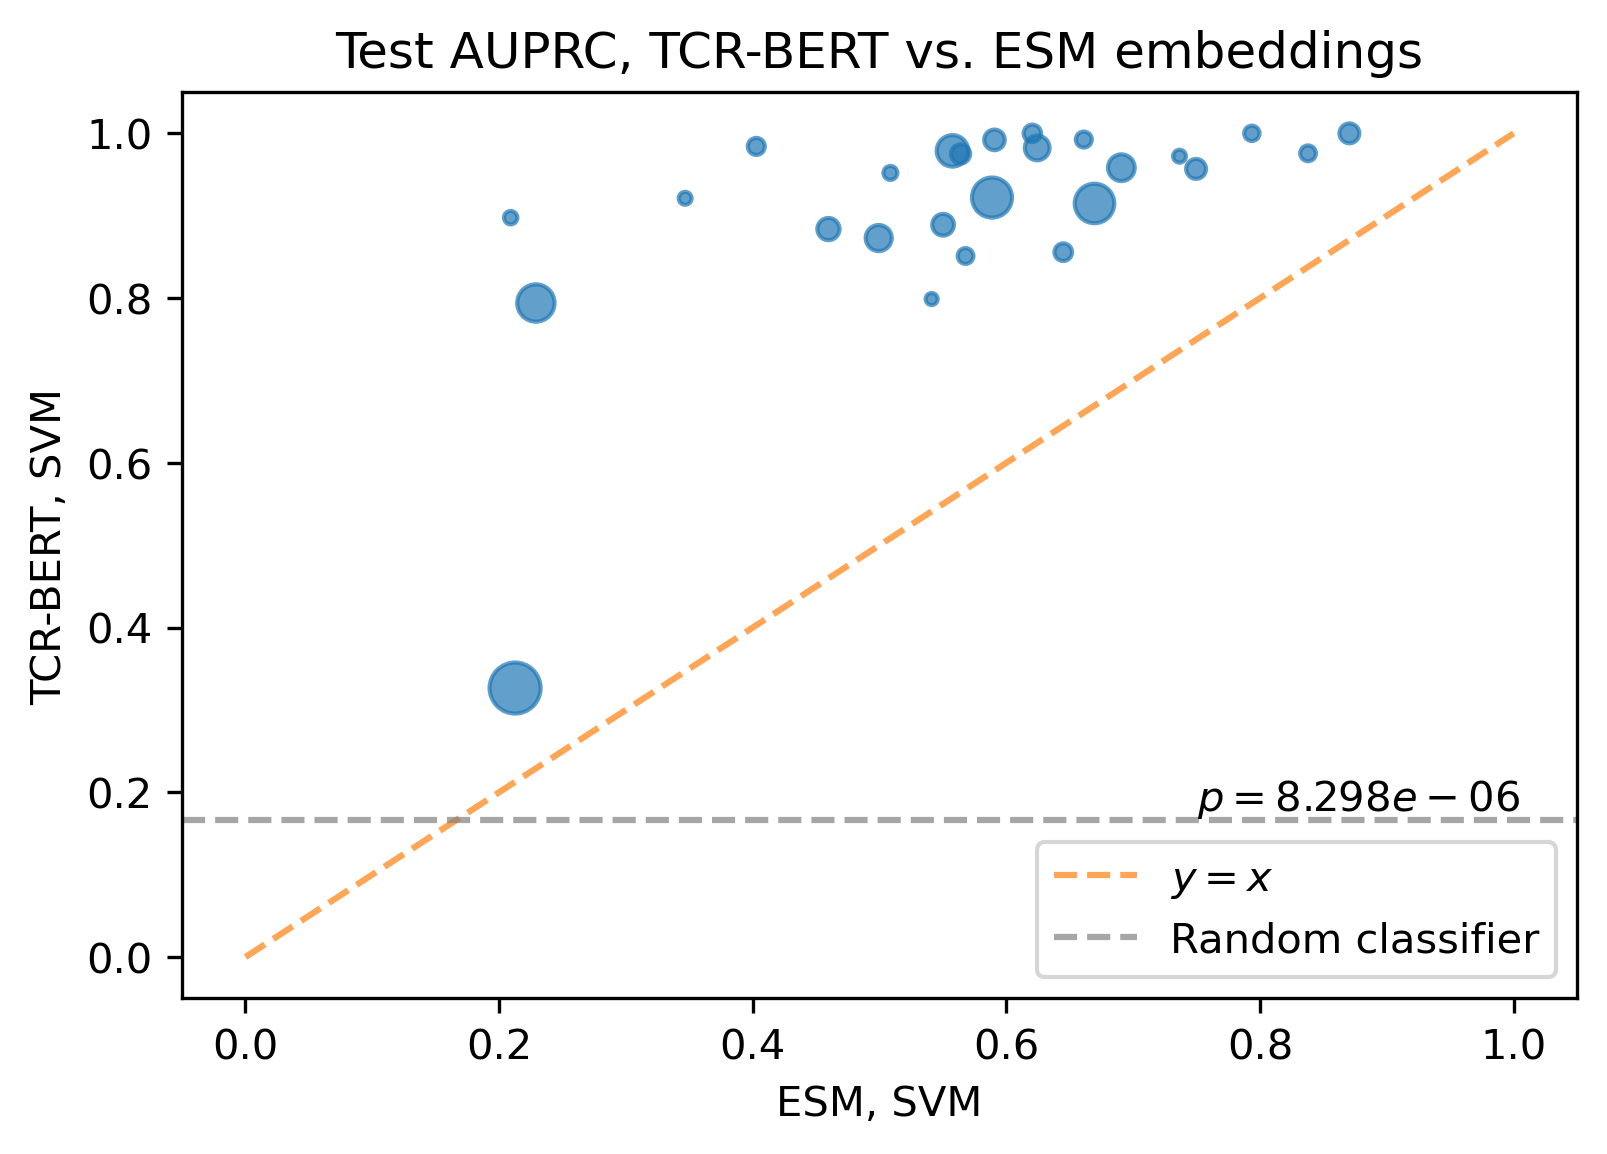

In [11]:
antigen_cv_plot(
    "ESM, SVM",
    "MLM + CLS, SVM",
    xlabel="ESM, SVM",
    ylabel="TCR-BERT, SVM",
    title="Test AUPRC, TCR-BERT vs. ESM embeddings",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_esm.pdf"),
).show()

Exceed in 26/26 cases


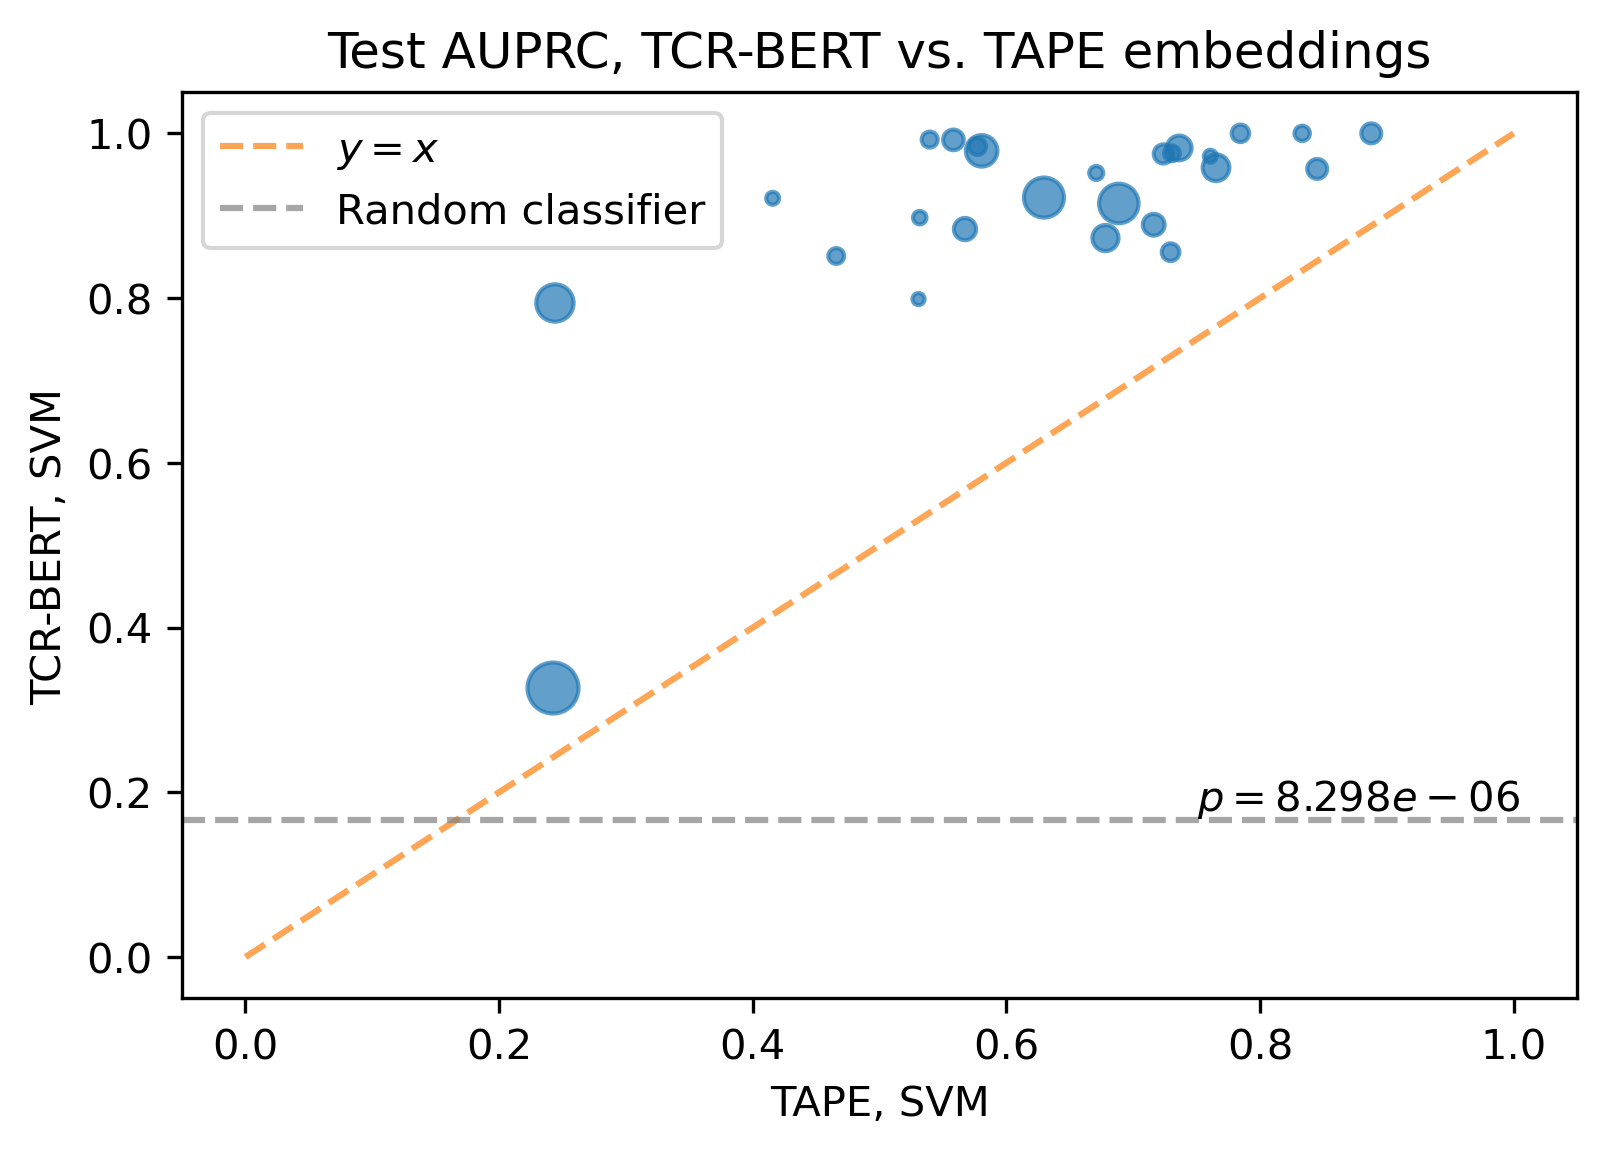

In [12]:
antigen_cv_plot(
    "TAPE, SVM",
    "MLM + CLS, SVM",
    xlabel="TAPE, SVM",
    ylabel="TCR-BERT, SVM",
    title="Test AUPRC, TCR-BERT vs. TAPE embeddings",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_tape.pdf"),
).show()

Exceed in 26/26 cases


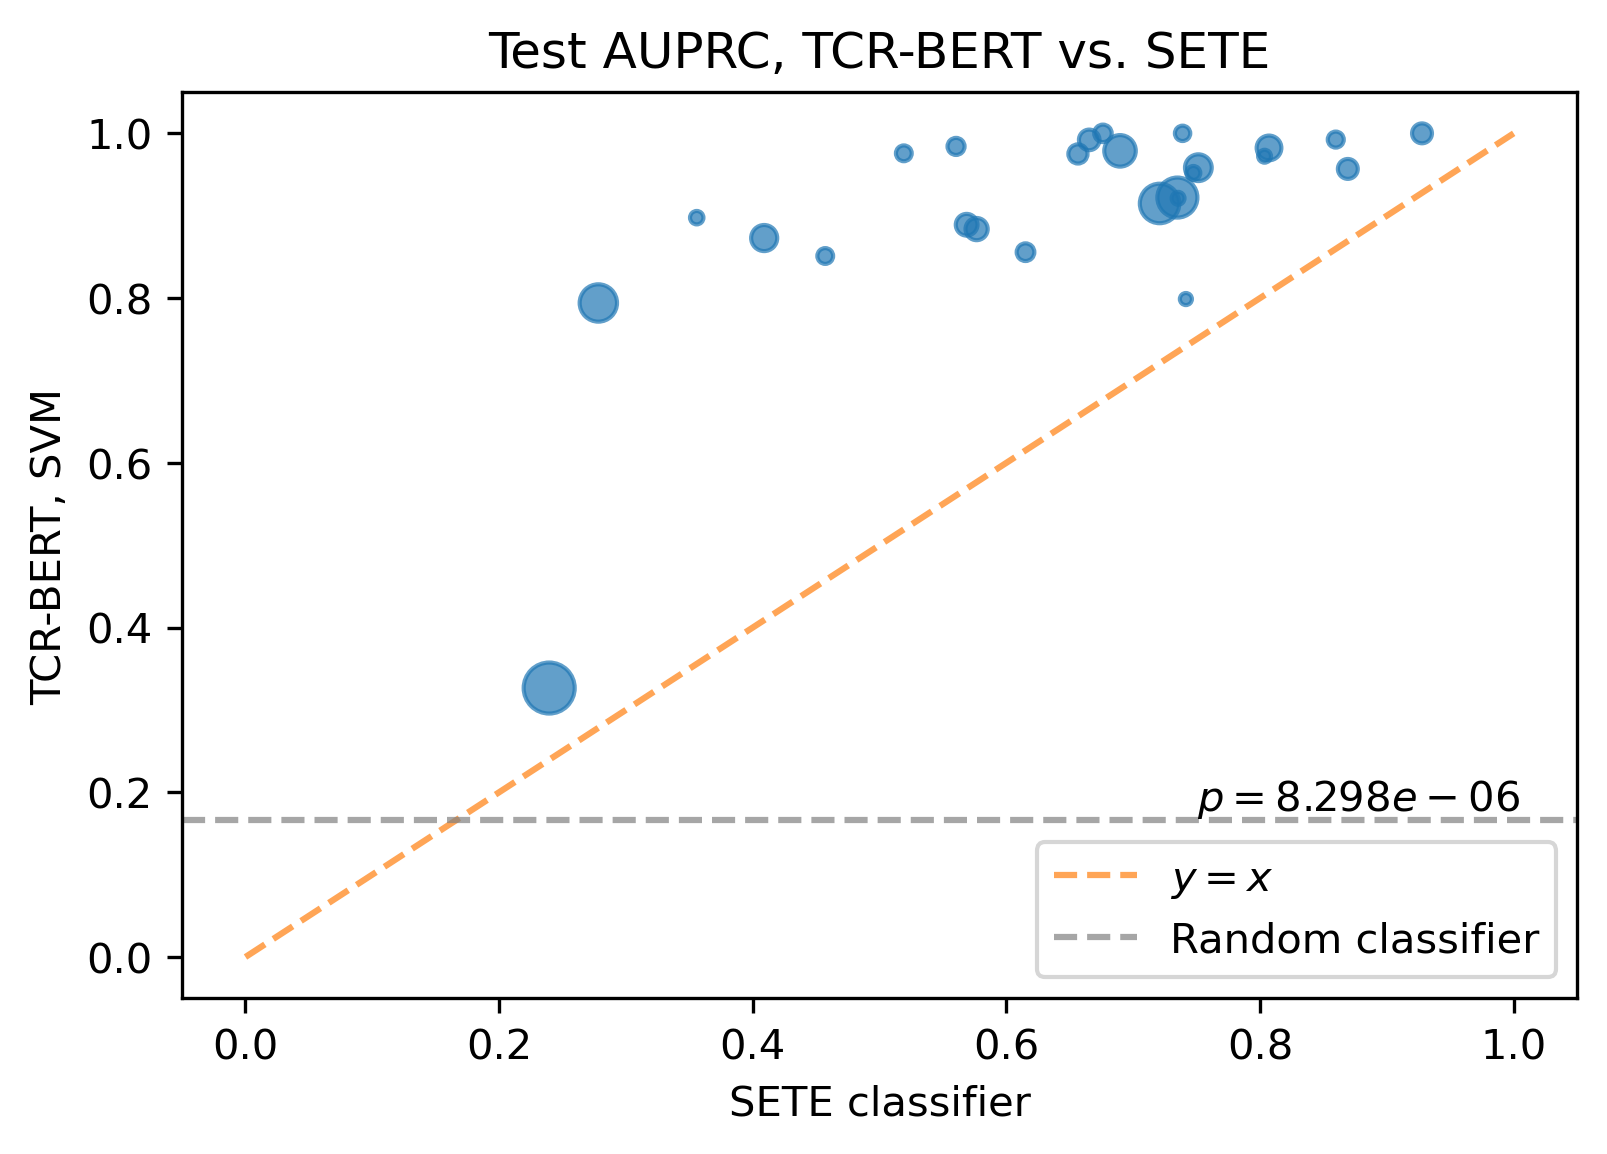

In [13]:
antigen_cv_plot(
    "SETE",
    "MLM + CLS, SVM",
    xlabel="SETE classifier",
    ylabel="TCR-BERT, SVM",
    title="Test AUPRC, TCR-BERT vs. SETE",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_sete.pdf"),
).show()

## Baseline comparisons

Exceed in 25/26 cases


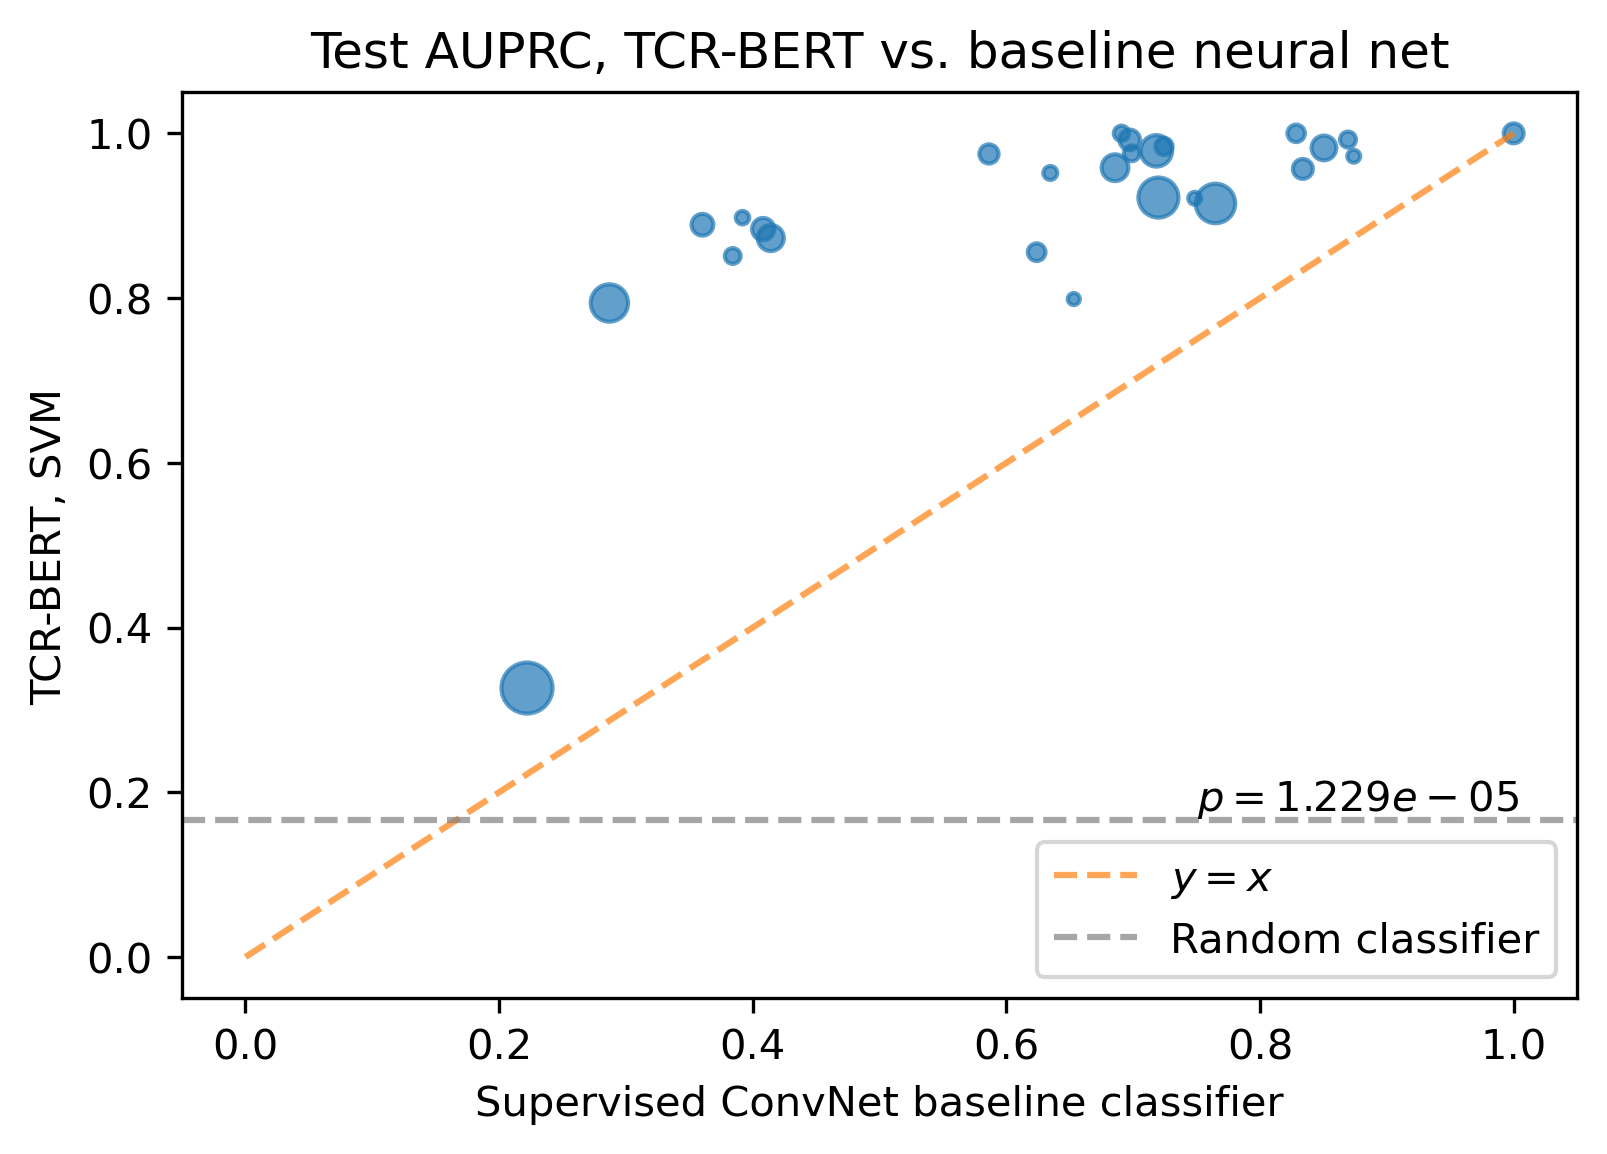

In [14]:
antigen_cv_plot(
    "ConvNet",
    "MLM + CLS, SVM",
    xlabel="Supervised ConvNet baseline classifier",
    ylabel="TCR-BERT, SVM",
    title="Test AUPRC, TCR-BERT vs. baseline neural net",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_convnet.pdf"),
).show()

Exceed in 26/26 cases


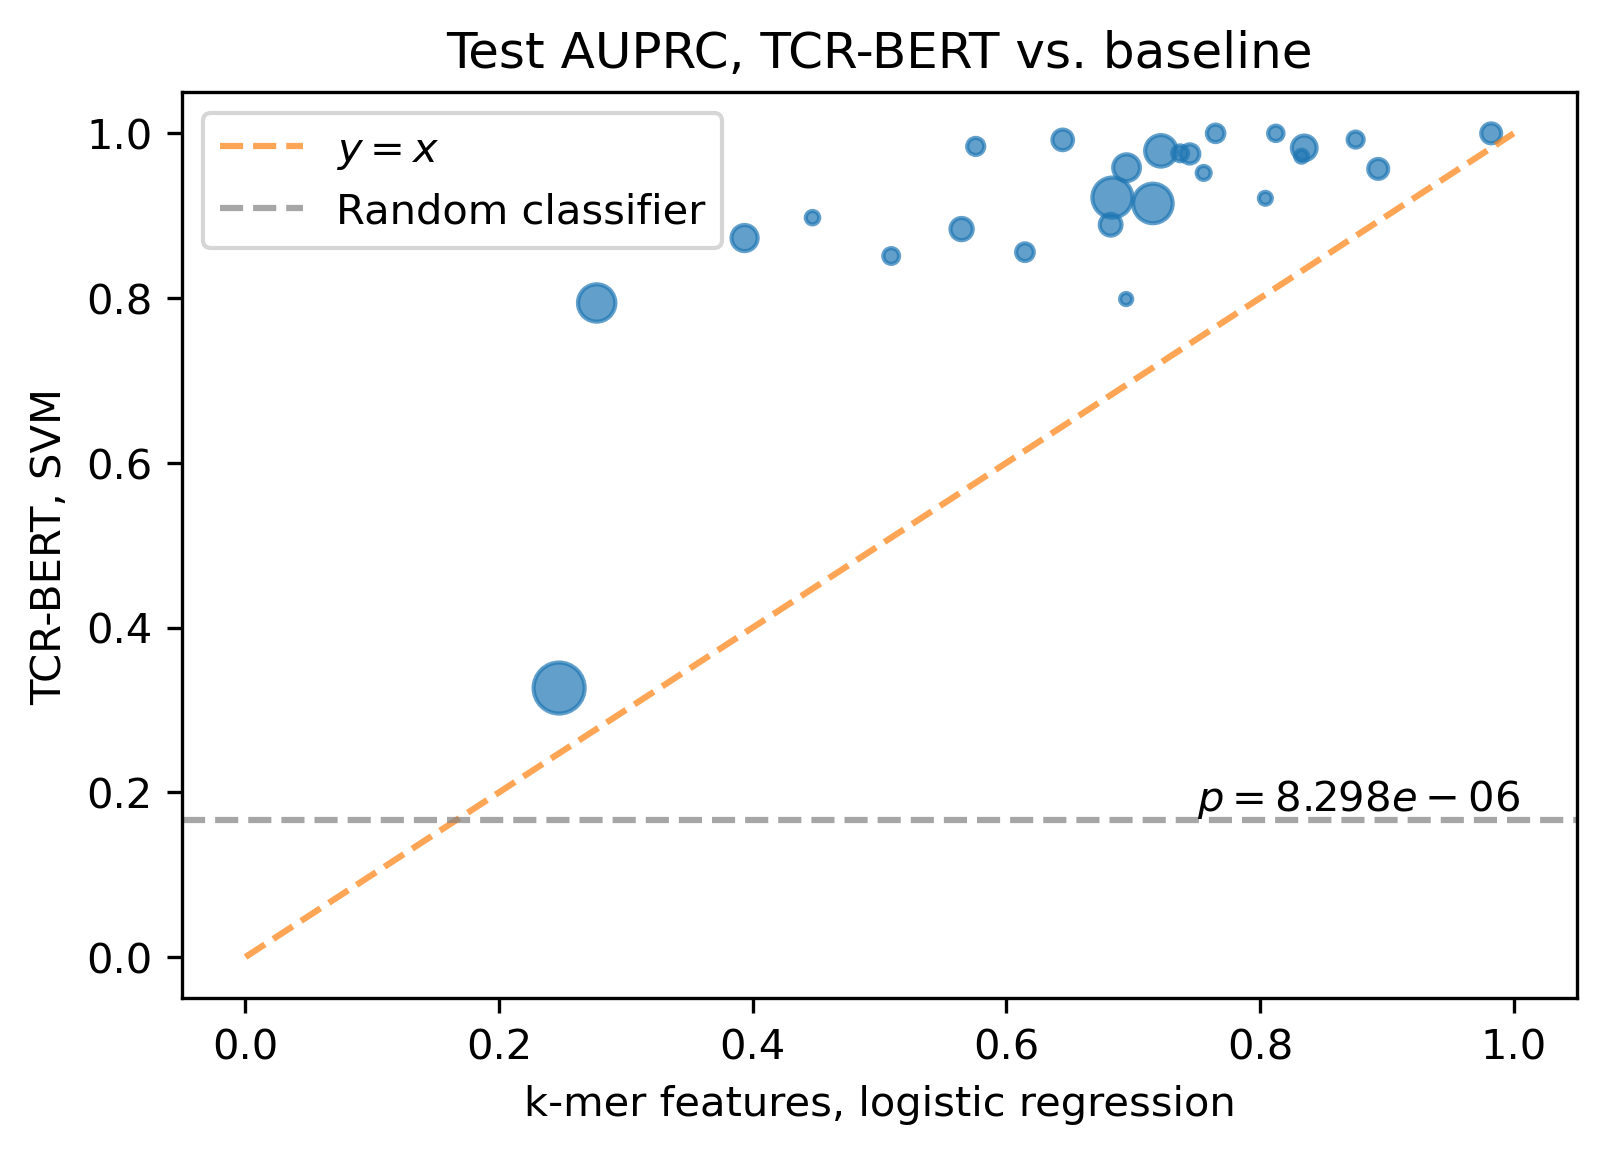

In [15]:
antigen_cv_plot(
    "k-mers, LR",
    "MLM + CLS, SVM",
    xlabel="k-mer features, logistic regression",
    ylabel="TCR-BERT, SVM",
    title="Test AUPRC, TCR-BERT vs. baseline",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_lr_kmers.pdf"),
).show()

## Compare SVM and LR

Make sure that the abofe results where TCR-BERT performs better isn't because the SVM model itself disadvantages other representations. We compare the classic logistic regression to evaluate this.

Exceed in 13/26 cases
Exceed in 19/26 cases


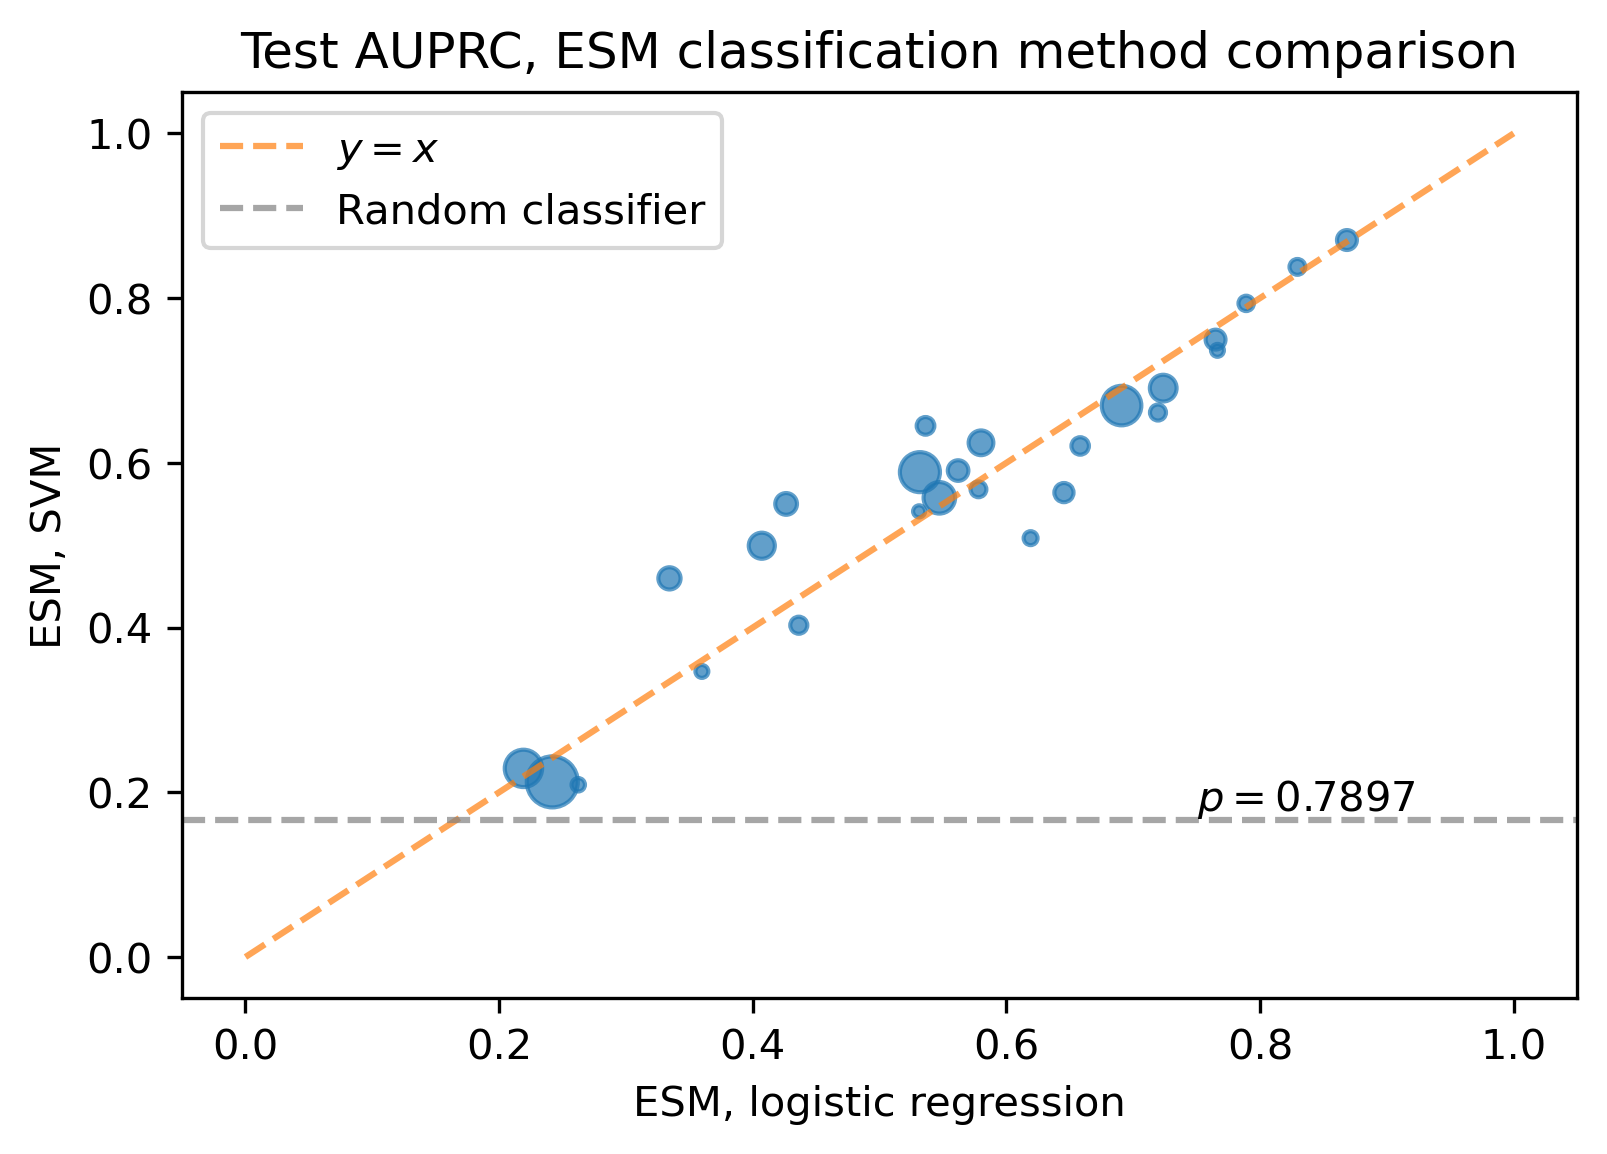

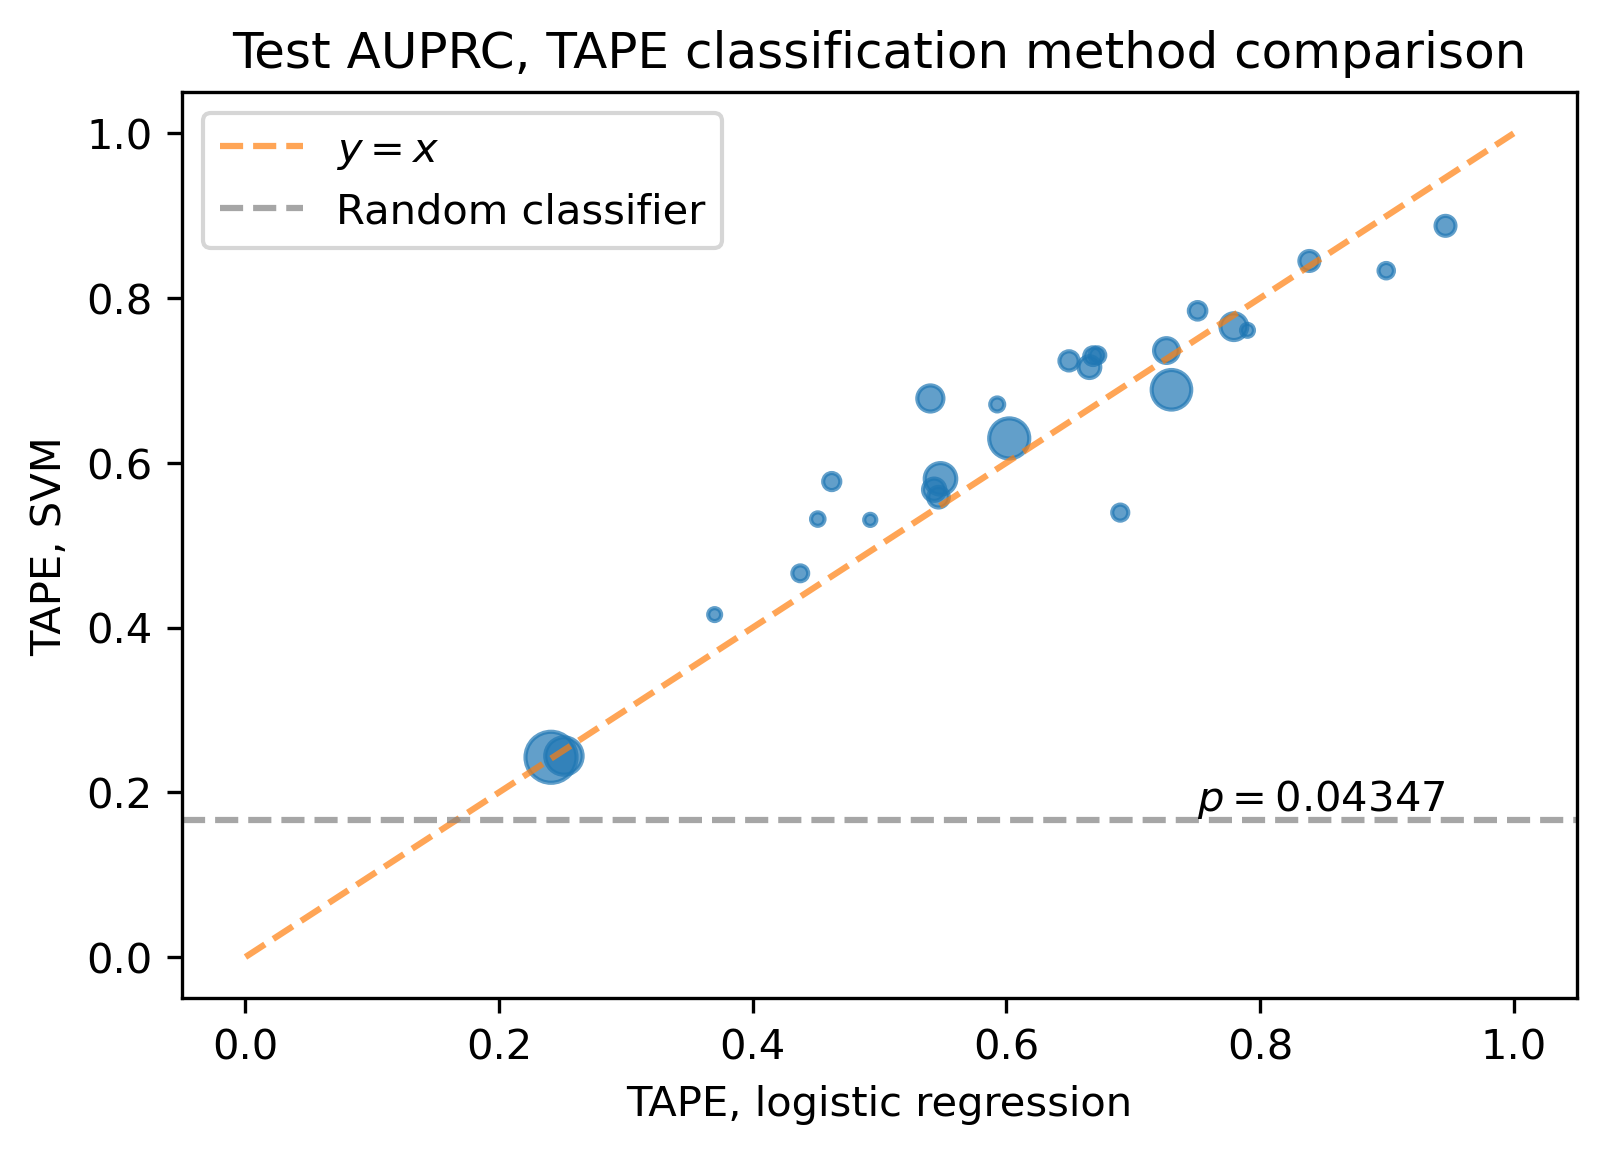

In [16]:
for rep in ['ESM', "TAPE"]:
    antigen_cv_plot(
        f"{rep}, LR",
        f"{rep}, SVM",
        xlabel=f"{rep}, logistic regression",
        ylabel=f"{rep}, SVM",
        title=f"Test AUPRC, {rep} classification method comparison",
        fname=os.path.join(PLOT_DIR, f"{rep}_lr_vs_svm.pdf"),
    ).show()

Exceed in 26/26 cases
Exceed in 26/26 cases


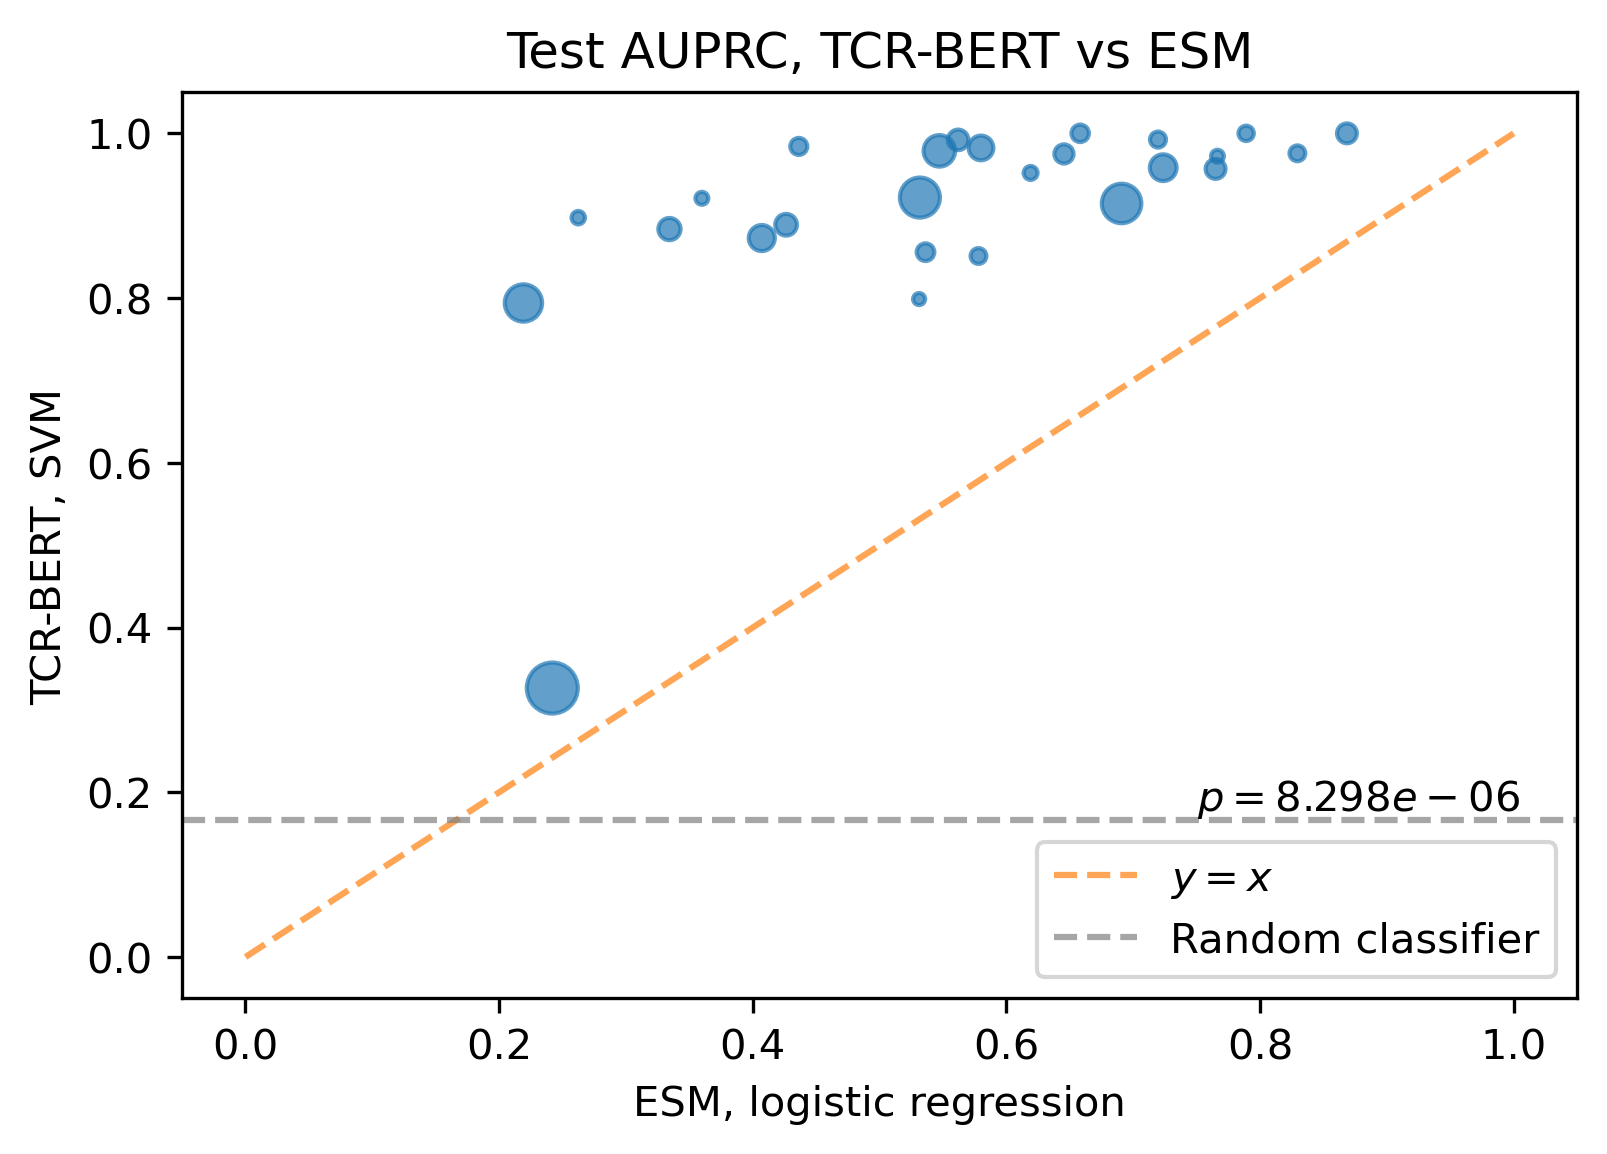

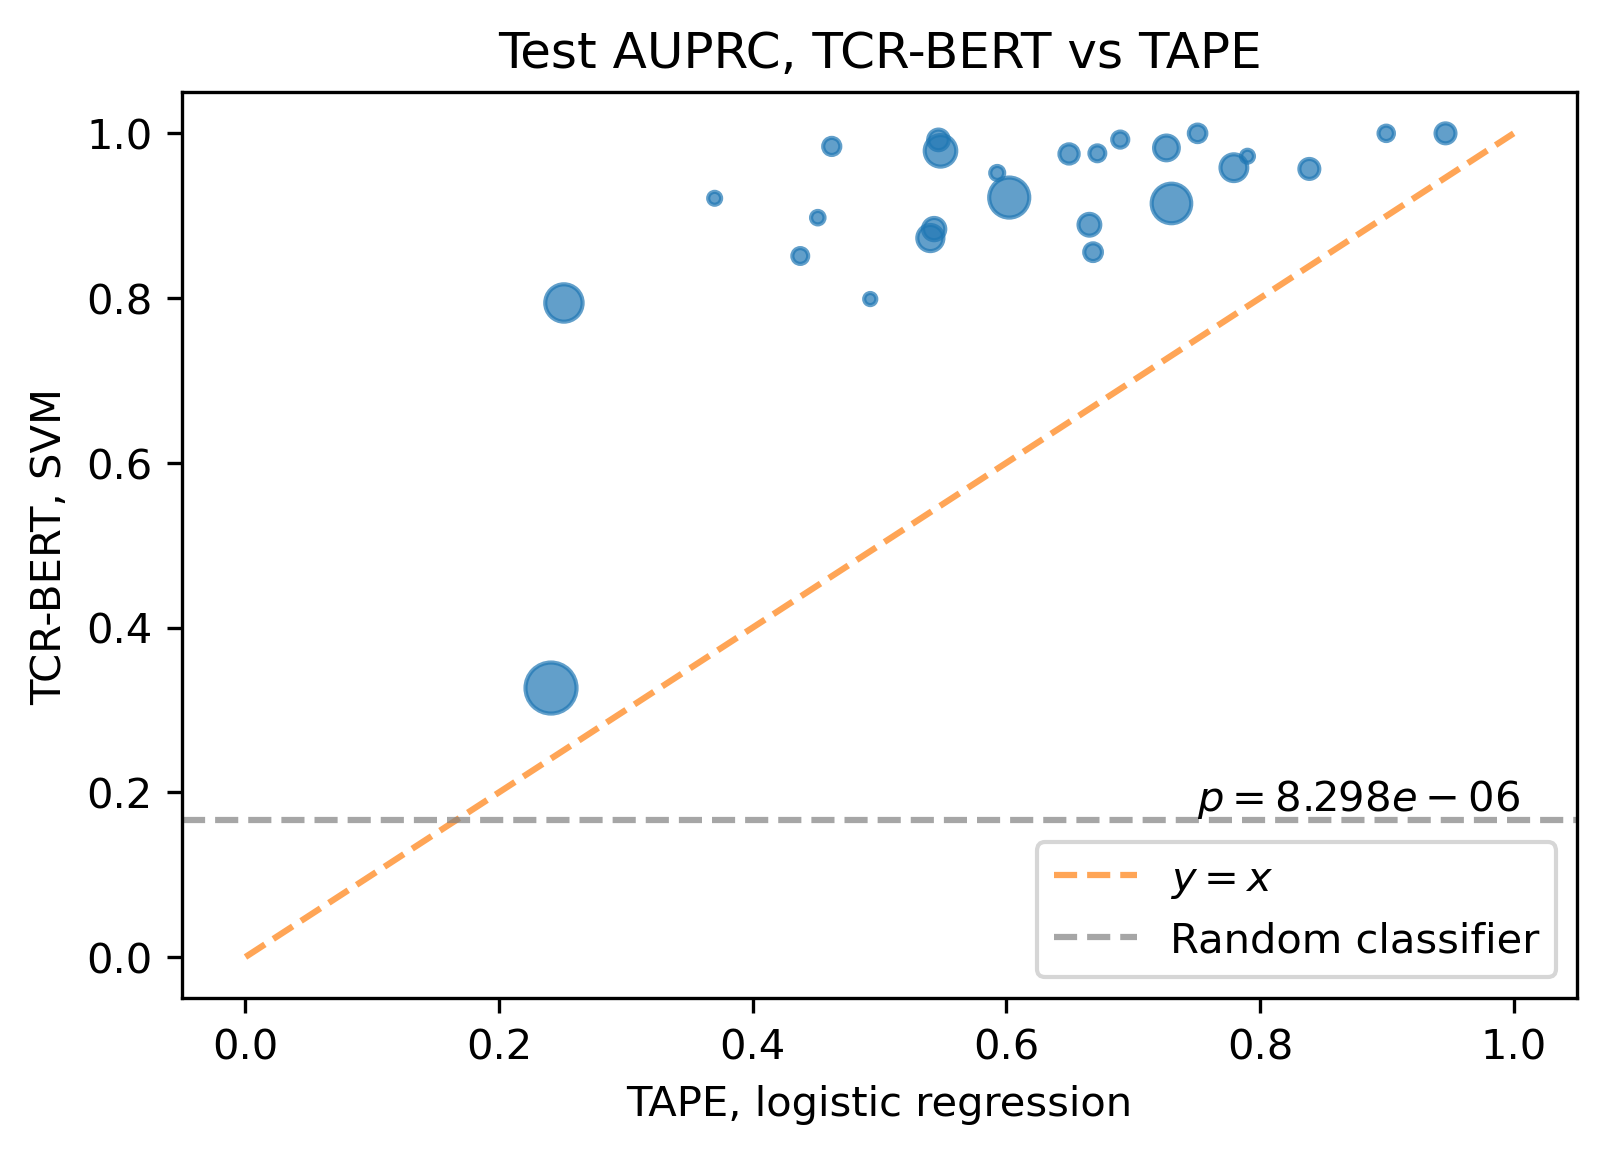

In [17]:
for rep in ['ESM', "TAPE"]:
    antigen_cv_plot(
        f"{rep}, LR",
        "MLM + CLS, SVM",
        xlabel=f"{rep}, logistic regression",
        ylabel=f"TCR-BERT, SVM",
        title=f"Test AUPRC, TCR-BERT vs {rep}",
        fname=os.path.join(PLOT_DIR, f"{rep}_lr_vs_tcrbert_svm.pdf"),
    ).show()

## How does MAA only TCR-BERT compare to ESM/TAPE?

Since these use similar training strategies, the results may be closer

Exceed in 21/26 cases
Exceed in 24/26 cases
Exceed in 22/26 cases
Exceed in 25/26 cases


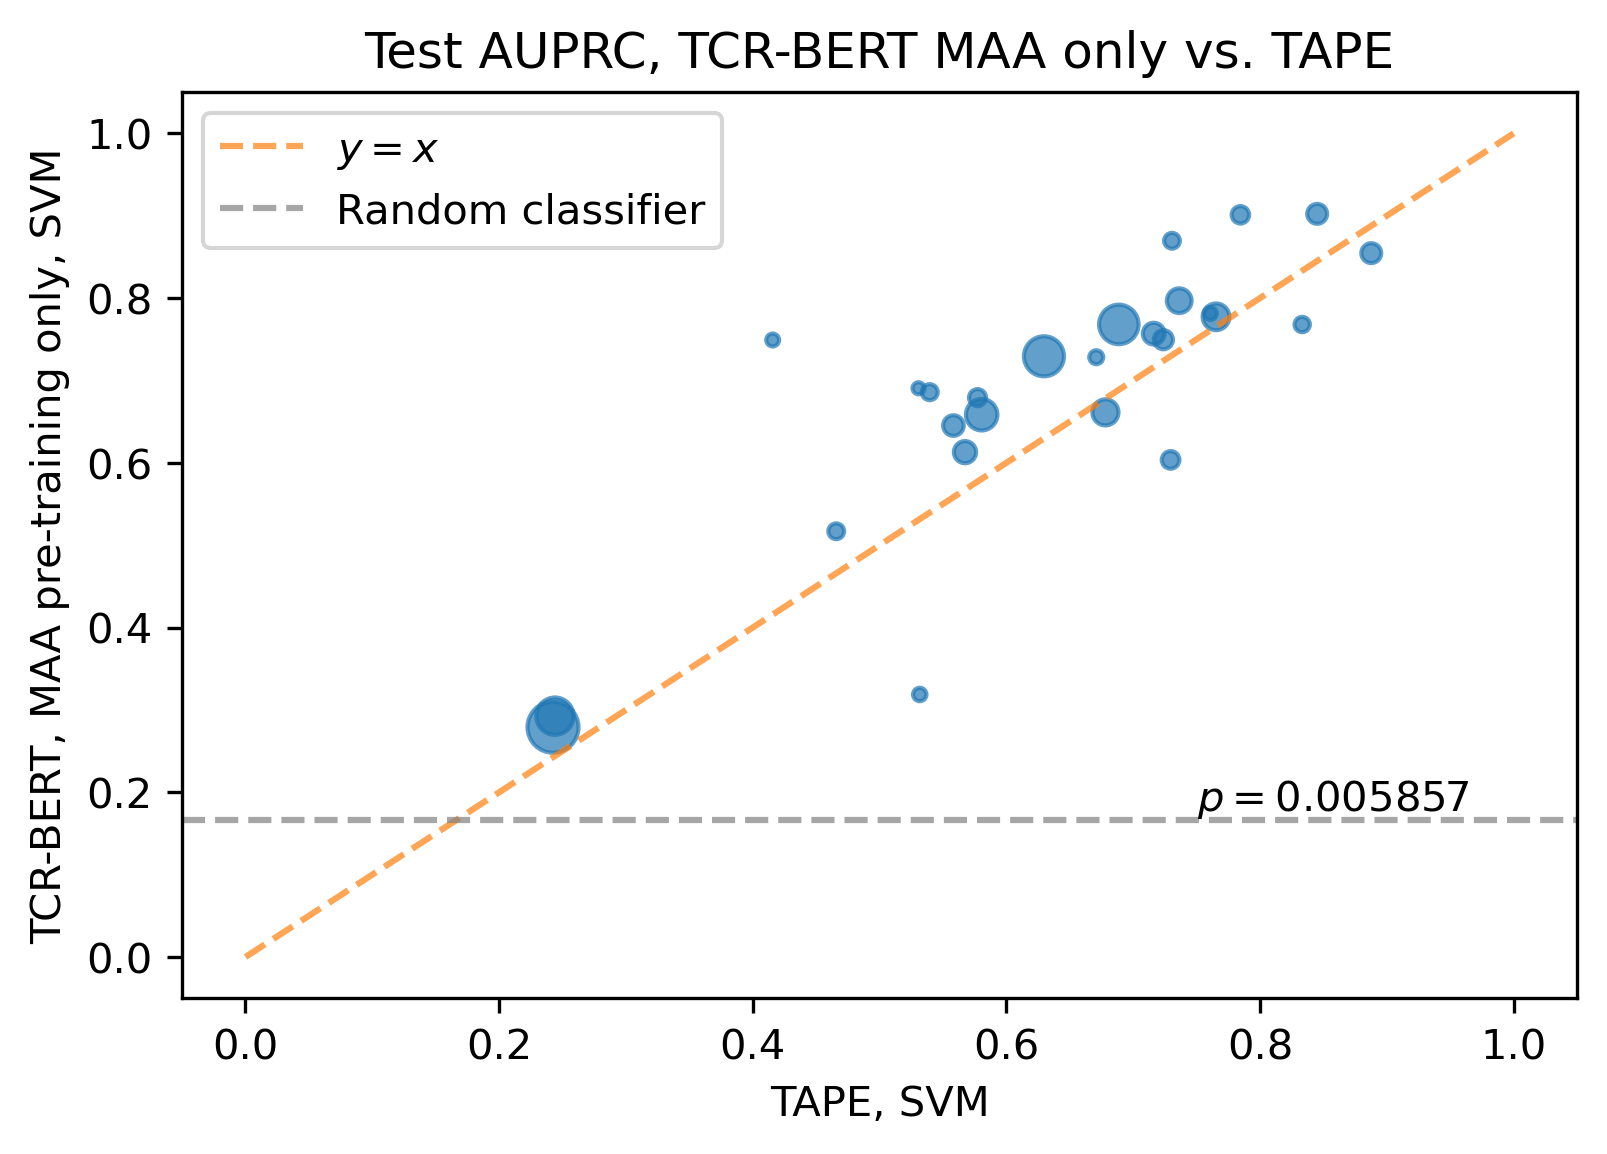

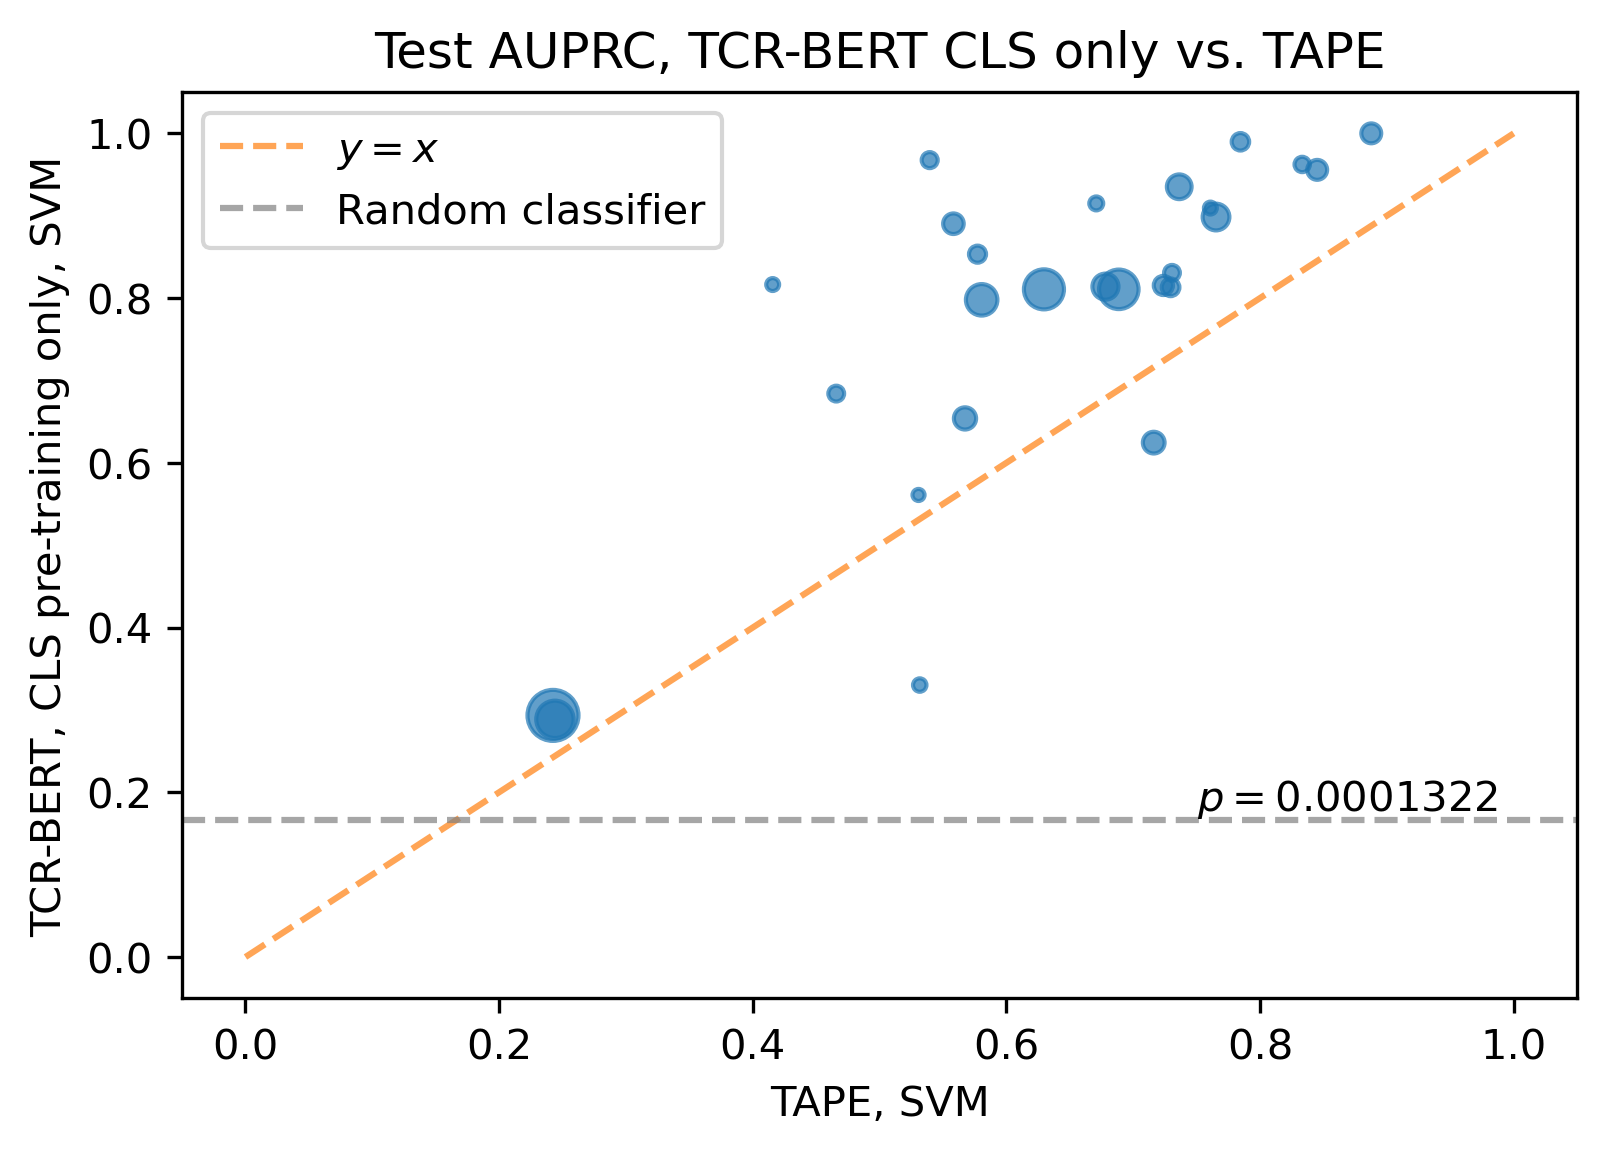

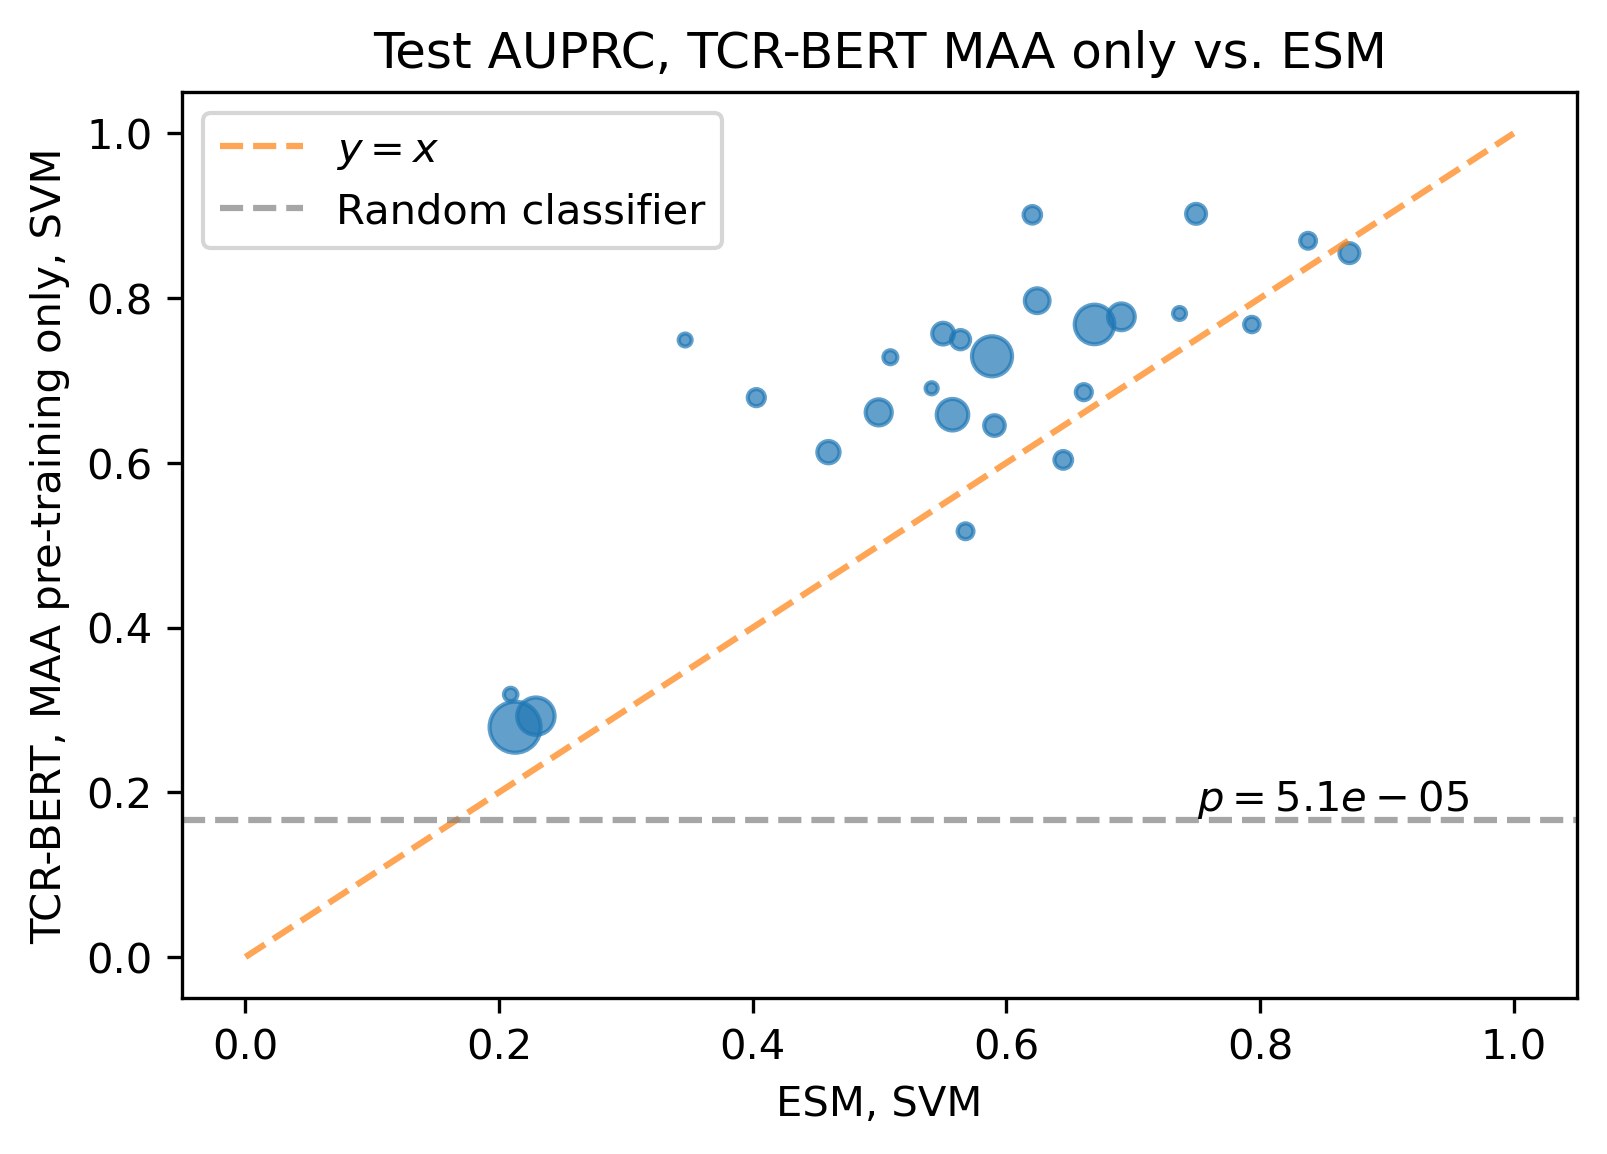

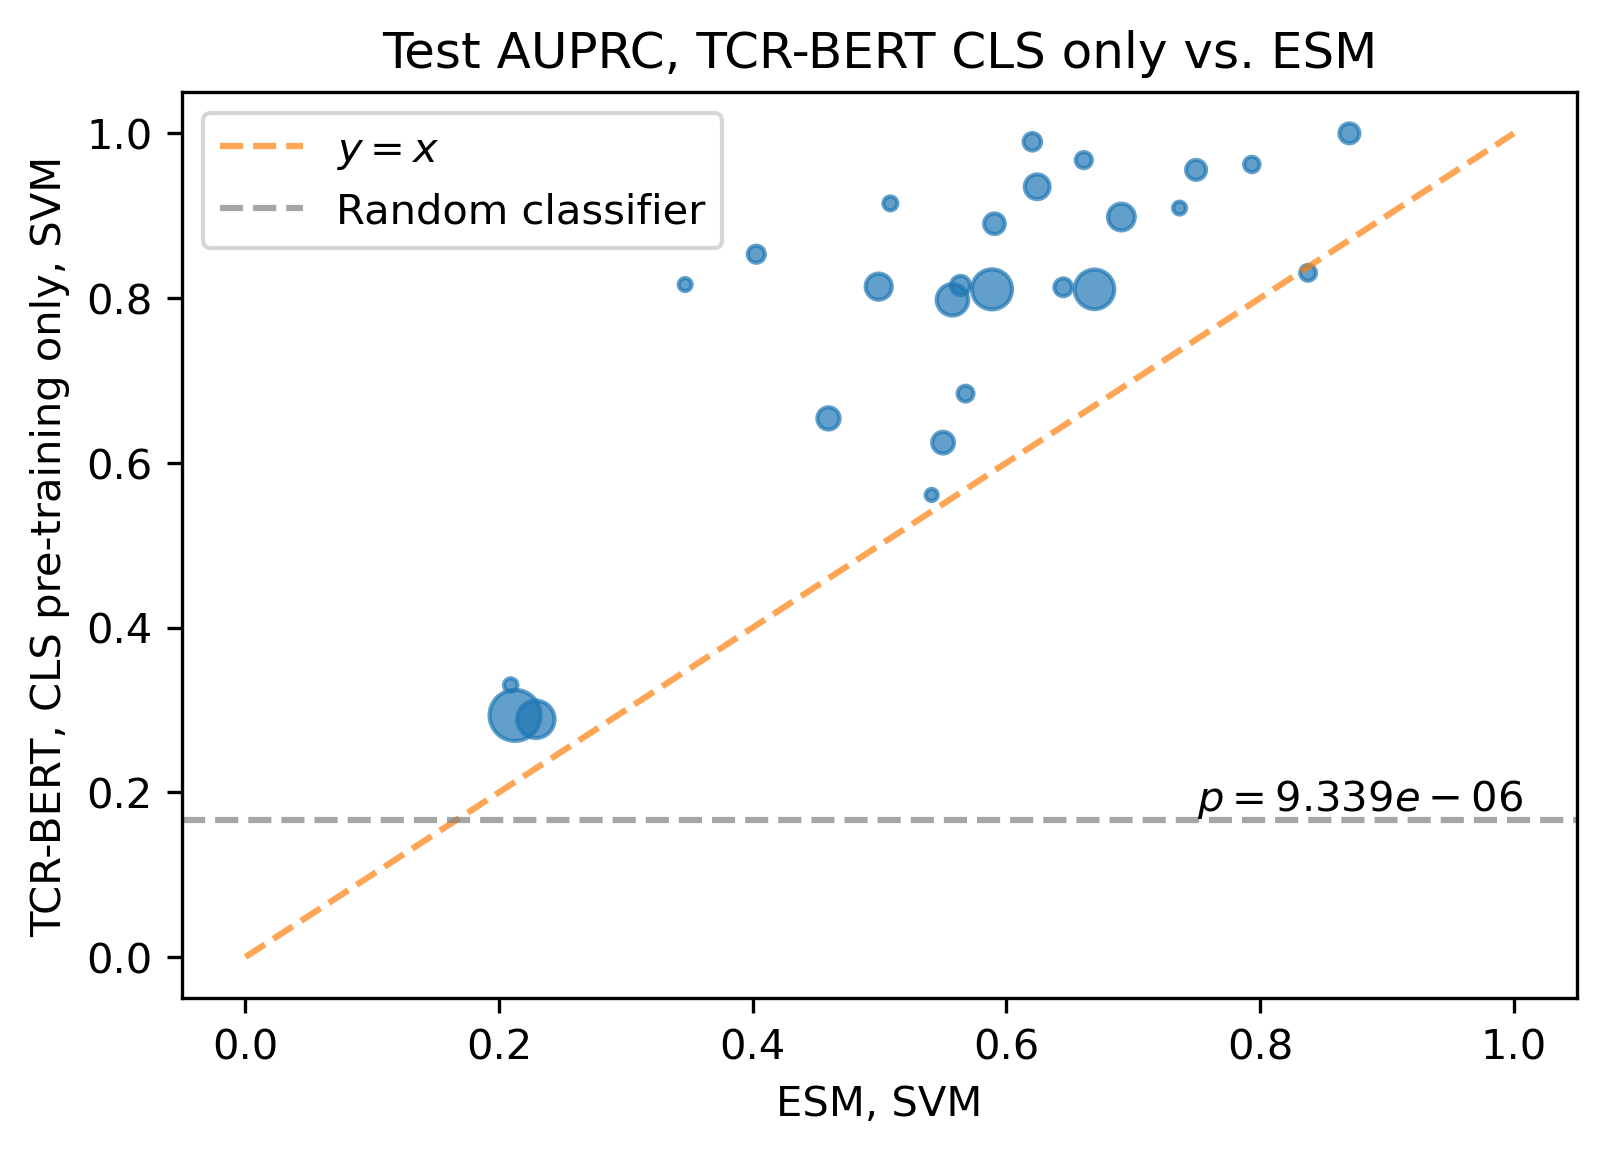

In [18]:
for m in ['TAPE', 'ESM']:
    antigen_cv_plot(
        f"{m}, SVM",
        "MLM, SVM",
        xlabel=f"{m}, SVM",
        ylabel="TCR-BERT, MAA pre-training only, SVM",
        title=f"Test AUPRC, TCR-BERT MAA only vs. {m}",
        fname=os.path.join(PLOT_DIR, f"mlm_vs_{m.lower()}.pdf"),
    ).show()
    antigen_cv_plot(
        f"{m}, SVM",
        "CLS, SVM",
        xlabel=f"{m}, SVM",
        ylabel="TCR-BERT, CLS pre-training only, SVM",
        title=f"Test AUPRC, TCR-BERT CLS only vs. {m}",
        fname=os.path.join(PLOT_DIR, f"cls_vs_{m.lower()}.pdf"),
    ).show()